# v0 AgriNet

The first task for the AI chain is to generate NIR images from RGB reference images to be further processed to yield NDVI and NDWI.
The model used will be the popular Pix2PixHD model from NVIDIA, which is a conditional GAN that learns a mapping from input images to output images.

In [57]:
import tensorflow as tf
import numpy as np

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# NIRScene0 Dataset
We need a set of pairs of RGB and NIR images to train the model. The dataset used is the [RGB-NIR Scene Data](http://ivrlwww.epfl.ch/supplementary_material/cvpr11/nirscene1.zip) from [EPFL](https://www.epfl.ch/labs/ivrl/research/downloads/rgb-nir-scene-dataset/), which contains 477 images in 9 scene categories (country, field, forest, indoor, mountain, oldbuilding, street, urban, water) at 1024x768 resolution.



In [58]:
dataset_path = pathlib.Path("/Users/adambyrne/Datasets/nirscene0/jpg1")

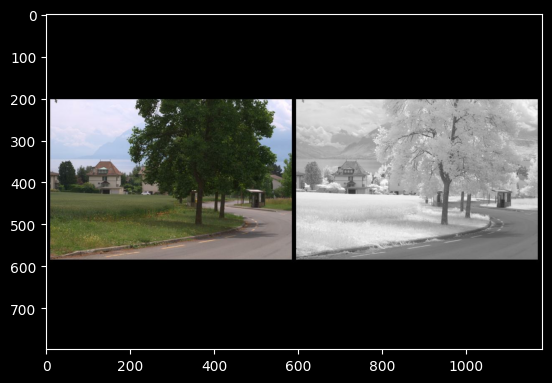

In [59]:
image_data = tf.io.read_file(str(dataset_path / "country_0000.jpg"))
image = tf.io.decode_jpeg(image_data)
plt.imshow(image.numpy())

You need to separate real building facade images from the architecture label images—all of which need to be `256 x 256` for the cGAN.

Define a function that loads image files and outputs two image tensors:

In [60]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])

    return real_image, input_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

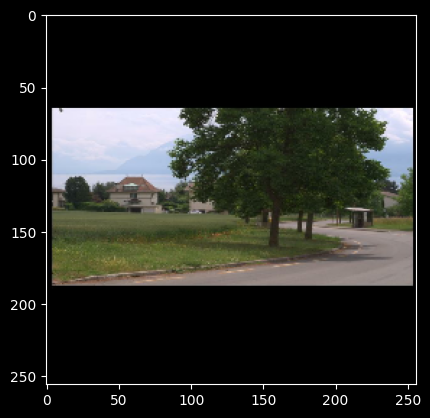

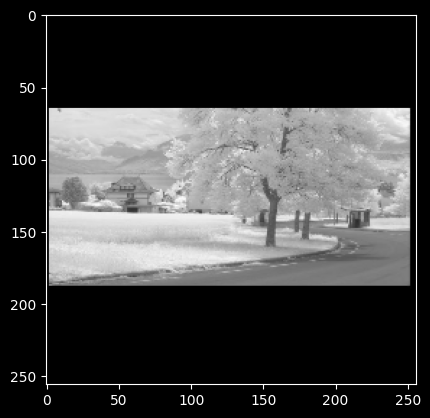

In [61]:
inp, re = load(str(dataset_path / "country_0000.jpg"))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [62]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [63]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [64]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]

In [65]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [66]:
@tf.function()
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

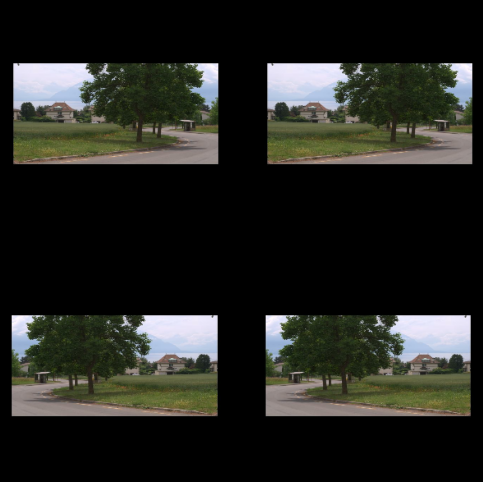

In [67]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [68]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [69]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Build an input pipeline with `tf.data`

In [70]:
train_dataset = tf.data.Dataset.list_files(
    "/Users/adambyrne/Datasets/nirscene0/jpg1/*.jpg"
)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [71]:
test_dataset = tf.data.Dataset.list_files(
    "/Users/adambyrne/Datasets/nirscene0/jpg2/*.jpg"
)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [72]:
OUTPUT_CHANNELS = 3

In [73]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [74]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [75]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [76]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [77]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

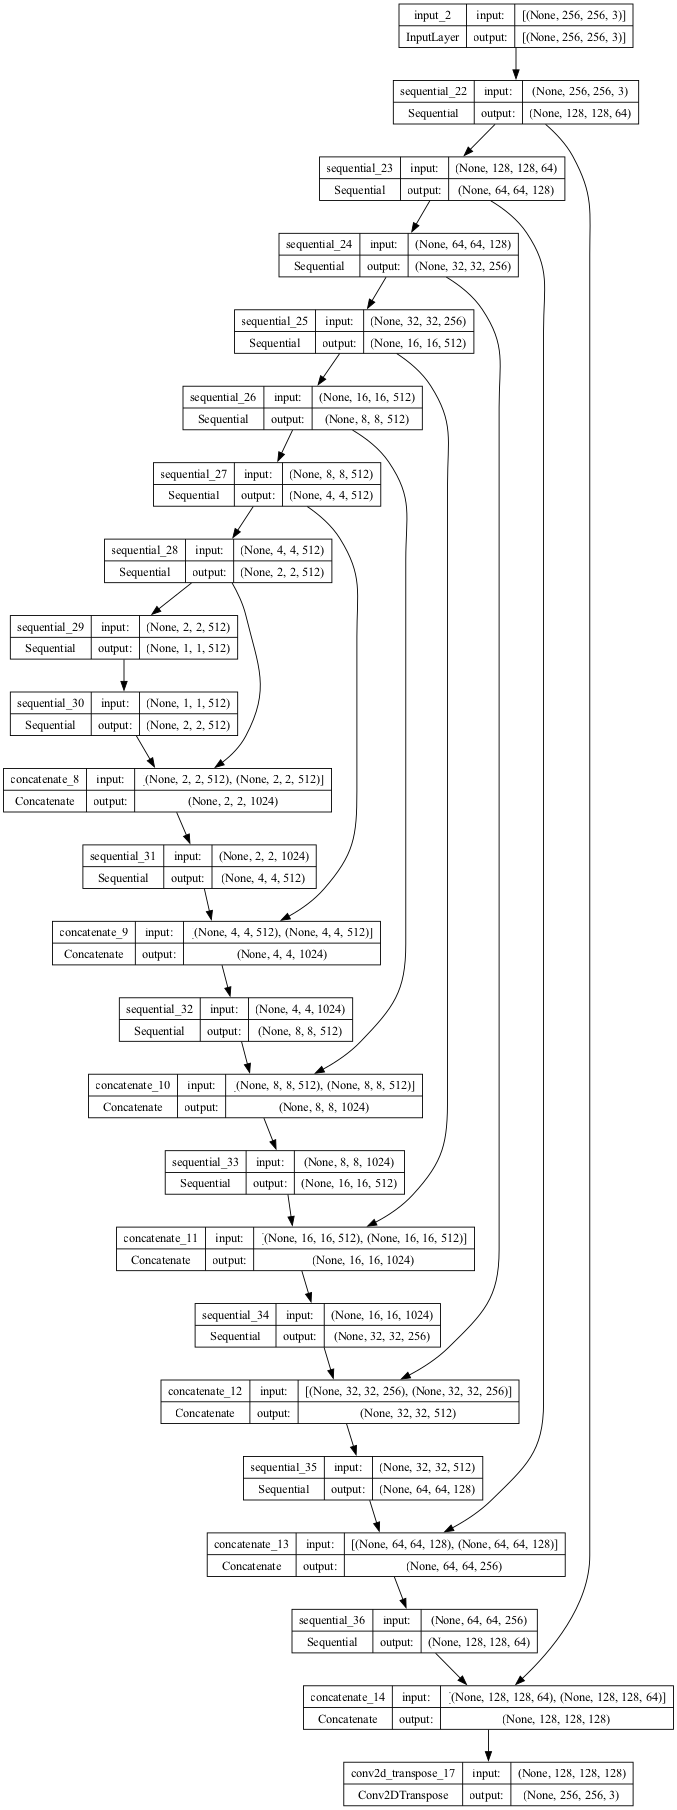

In [78]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


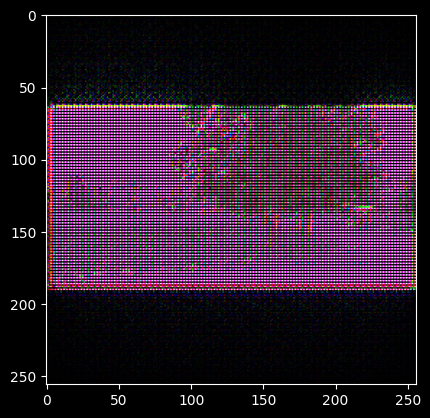

In [79]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [80]:
LAMBDA = 100

In [81]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [82]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [83]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name="target_image")

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(
        zero_pad1
    )  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        zero_pad2
    )  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

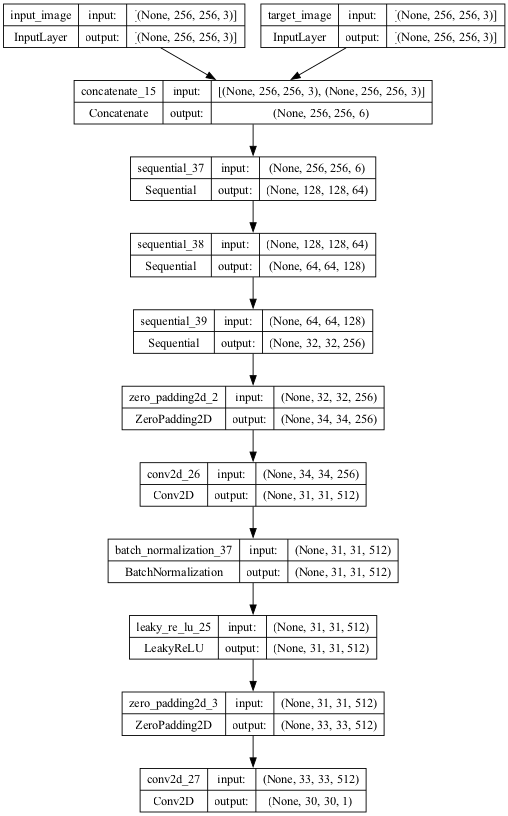

In [84]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

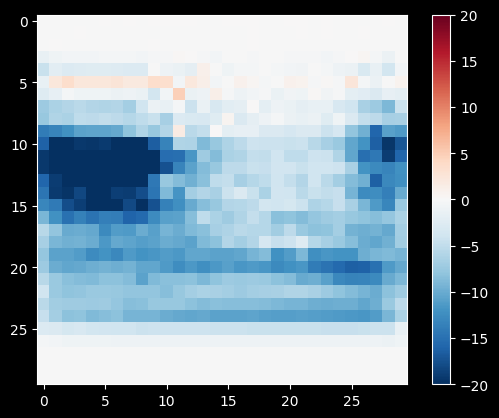

In [85]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [86]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [87]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [88]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [89]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()

Test the function:

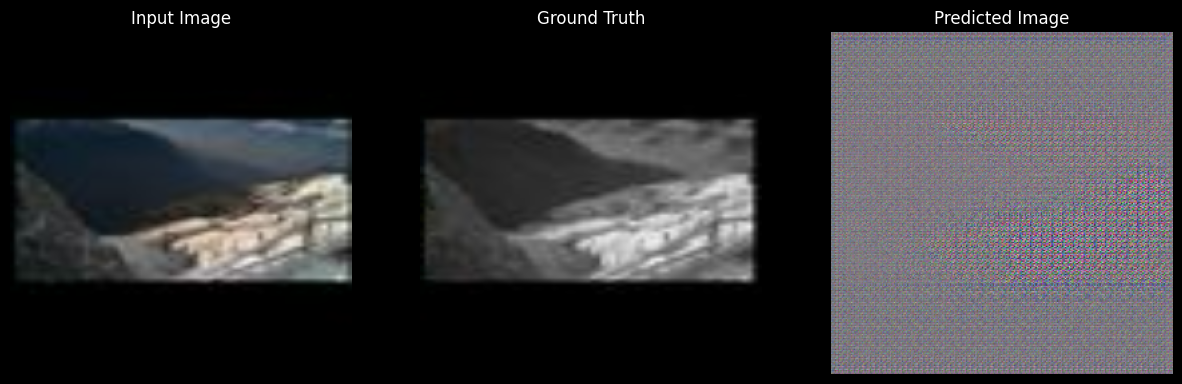

In [90]:
for example_input, example_target in test_dataset.take(1):
    # resize imp to 256x256
    example_input = tf.image.resize(example_input, [256, 256])
    example_target = tf.image.resize(example_target, [256, 256])
    generate_images(generator, example_input, example_target)

In [91]:
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [92]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step // 1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step // 1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step // 1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step // 1000)

In [93]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    example_input = tf.image.resize(example_input, [256, 256])
    example_target = tf.image.resize(example_target, [256, 256])

    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 10 == 0:
            display.clear_output(wait=True)
            start = time.time()

            generate_images(generator, example_input, example_target)
            if step % 10 == 0:
                print(f"Epoch: {step}")

        train_step(input_image, target, step)

        # Training step
        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)

        if (step + 1) % 50 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Finally, run the training loop:

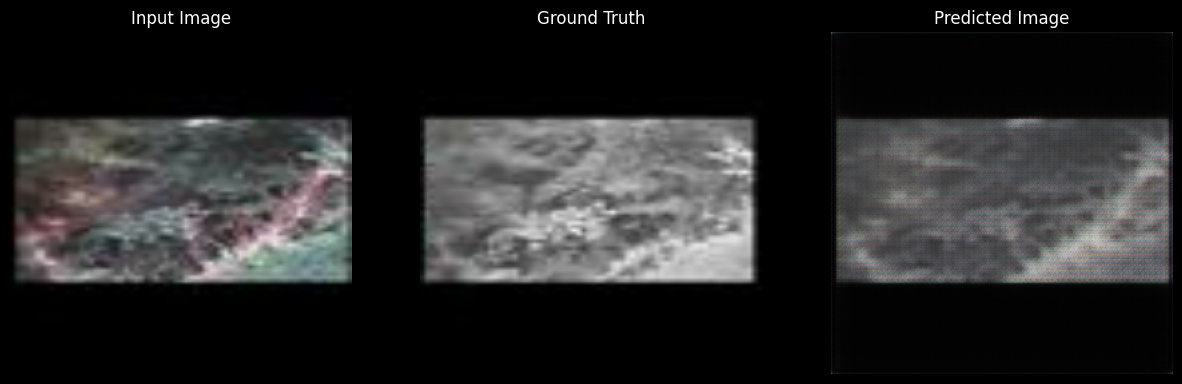

Epoch: 90
.

In [94]:
fit(train_dataset, test_dataset, steps=100)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

In [95]:
!ls {checkpoint_dir}

checkpoint                   ckpt-48.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-48.index
ckpt-1.index                 ckpt-49.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-49.index
ckpt-10.index                ckpt-5.data-00000-of-00001
ckpt-100.data-00000-of-00001 ckpt-5.index
ckpt-100.index               ckpt-50.data-00000-of-00001
ckpt-101.data-00000-of-00001 ckpt-50.index
ckpt-101.index               ckpt-51.data-00000-of-00001
ckpt-102.data-00000-of-00001 ckpt-51.index
ckpt-102.index               ckpt-52.data-00000-of-00001
ckpt-103.data-00000-of-00001 ckpt-52.index
ckpt-103.index               ckpt-53.data-00000-of-00001
ckpt-104.data-00000-of-00001 ckpt-53.index
ckpt-104.index               ckpt-54.data-00000-of-00001
ckpt-105.data-00000-of-00001 ckpt-54.index
ckpt-105.index               ckpt-55.data-00000-of-00001
ckpt-106.data-00000-of-00001 ckpt-55.index
ckpt-106.index               ckpt-56.data-00000-of-00001
ckpt-107.data-00000-of-00001 ckpt-56.index
ck

In [96]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

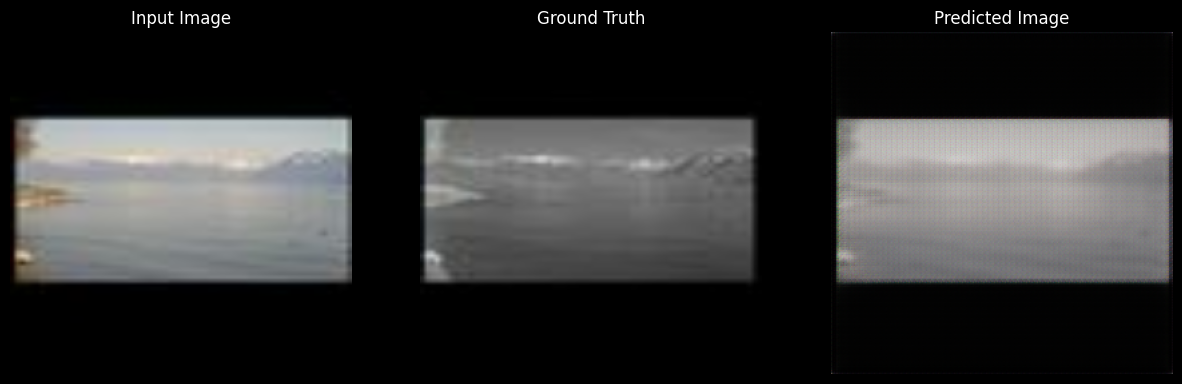

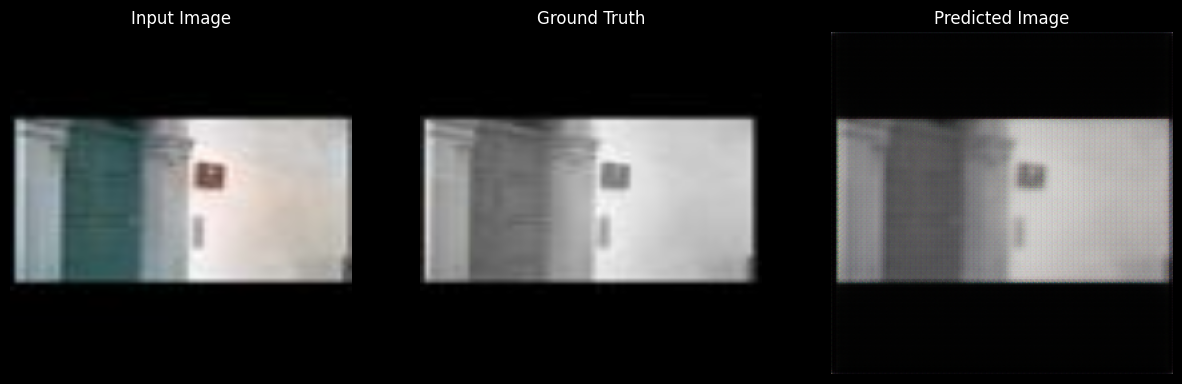

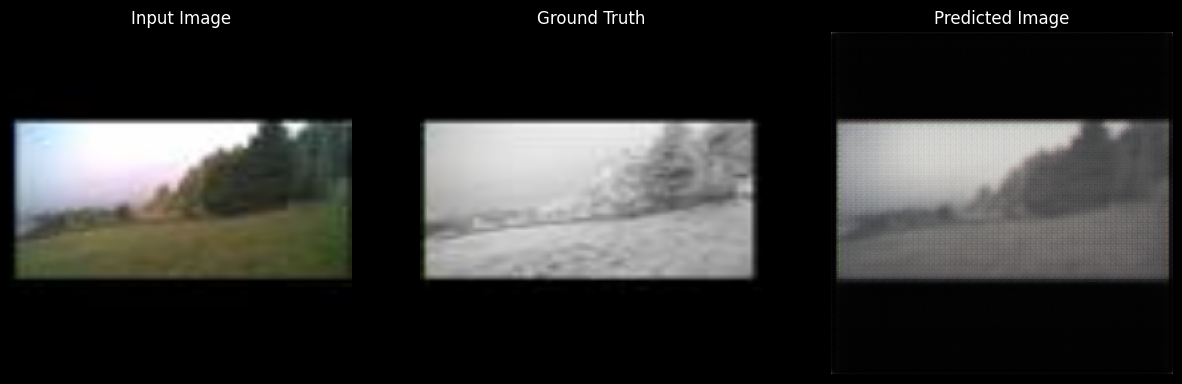

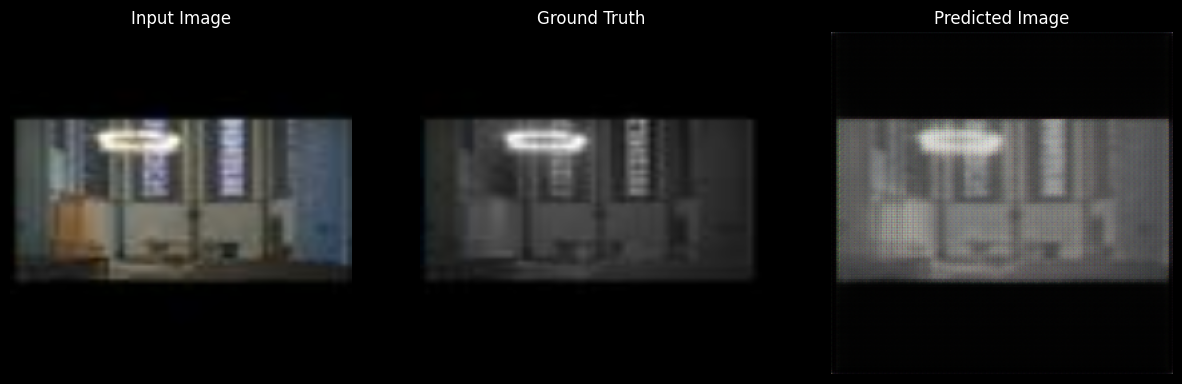

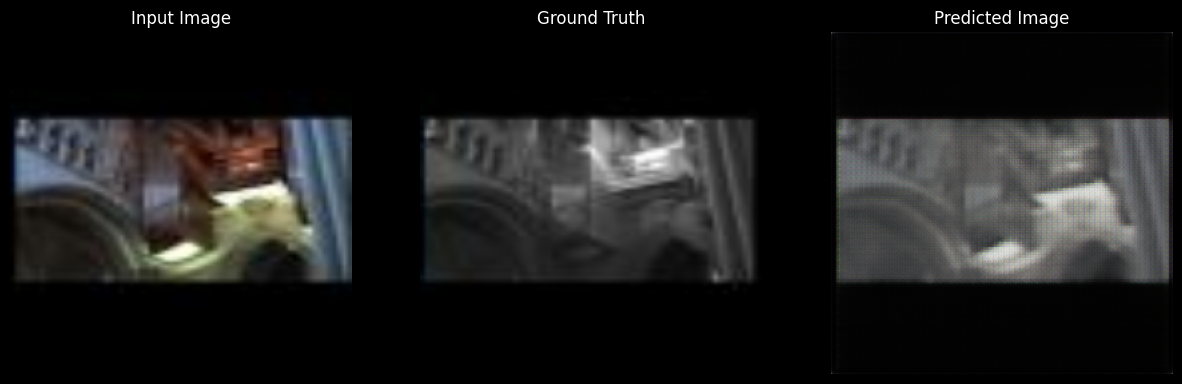

In [97]:
for inp, tar in test_dataset.take(5):
    inp = tf.image.resize(inp, [256, 256])
    tar = tf.image.resize(tar, [256, 256])
    generate_images(generator, inp, tar)

# Indices
Let's calculate the NDVI and NDWI indices from the generated NIR images and compare to ground truth indices.

In [165]:
def plot_graphs(images, titles, figsize=(15, 15)):
    plt.figure(figsize=figsize)

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])
        plt.axis("off")

## NDVI
Normalized Difference Vegetation Index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, typically, but not necessarily, from a space platform, and assess whether the target being observed contains live green vegetation or not.

`NDVI = (NIR - Red) / (NIR + Red)`

In [98]:
def normalize(img, min, max):
    return (img - min) / (max - min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


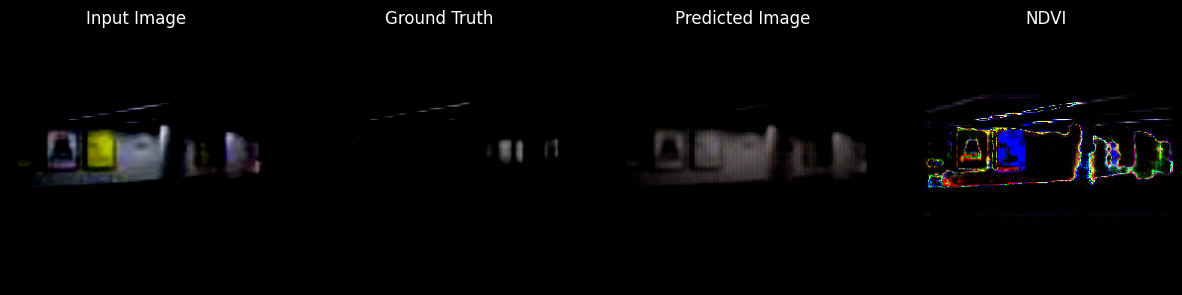

In [168]:
def nir_to_ndvi(nir, red):
    vi = (nir - red) / (nir + red)
    return normalize(vi, 0, 1)

inp, tar = next(iter(test_dataset.take(1)))
inp = tf.image.resize(inp, [256, 256])
tar = tf.image.resize(tar, [256, 256])
prediction = generator(inp, training=False)
ndvi = nir_to_ndvi(prediction, inp)

plot_graphs([inp[0], tar[0], prediction[0], ndvi[0]], ["Input Image", "Ground Truth", "Predicted Image", "NDVI"])

## NDWI
Normalized Difference Water Index (NDWI) is a normalized index of NIR and SWIR bands that is used globally in water detection.

`NDWI = (Green - NIR) / (Green + NIR)`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


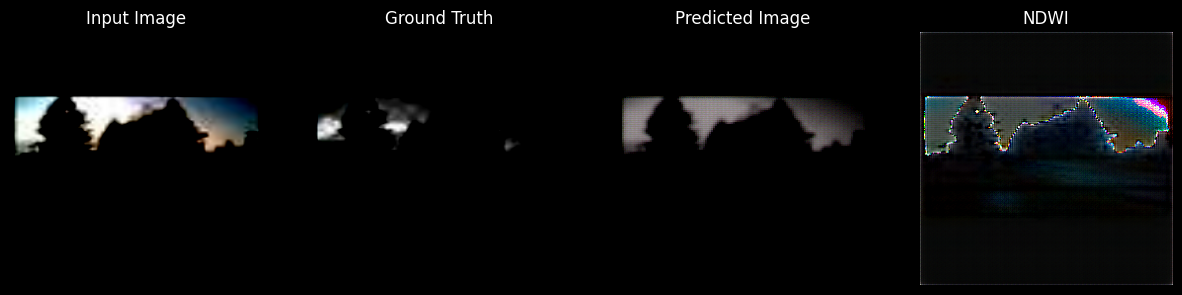

In [170]:
def nir_to_ndwi(nir, green):
    wi = (green - nir) / (green + nir)
    return normalize(wi, 0, 1)

inp, tar = next(iter(test_dataset.take(1)))
inp = tf.image.resize(inp, [256, 256])
tar = tf.image.resize(tar, [256, 256])
prediction = generator(inp, training=False)
ndwi = nir_to_ndwi(prediction, inp)

display_list = [inp[0], tar[0], prediction[0], ndwi[0]]
title = ["Input Image", "Ground Truth", "Predicted Image", "NDWI"]

plot_graphs([inp[0], tar[0], prediction[0], ndwi[0]], ["Input Image", "Ground Truth", "Predicted Image", "NDWI"])


# Demo Pipeline

(-0.5, 2612.5, 1959.5, -0.5)

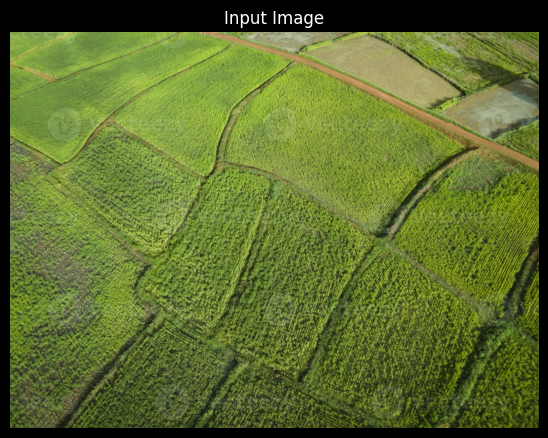

In [116]:
image_path = "../assets/green-field.jpg"
image_data = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image_data)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis("off")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


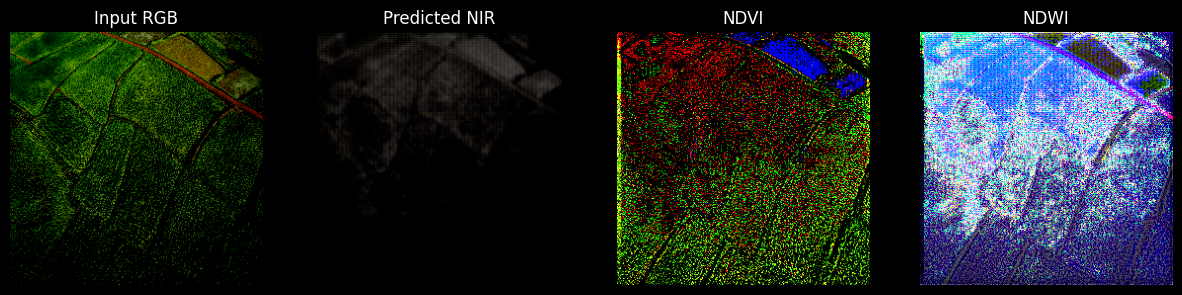

In [172]:
inp = tf.image.resize(image, [256, 256])
inp = tf.cast(inp, tf.float32)
inp = (inp / 127.5) - 1
inp = tf.expand_dims(inp, axis=0)
prediction = generator(inp, training=False)
ndvi = nir_to_ndvi(prediction, inp)
ndwi = nir_to_ndwi(prediction, inp)

plot_graphs([inp[0], prediction[0], ndvi[0], ndwi[0]], ["Input RGB", "Predicted NIR", "NDVI", "NDWI"])

## Analyze the results
Let's have a look at the distribution of the indices for the generated images.

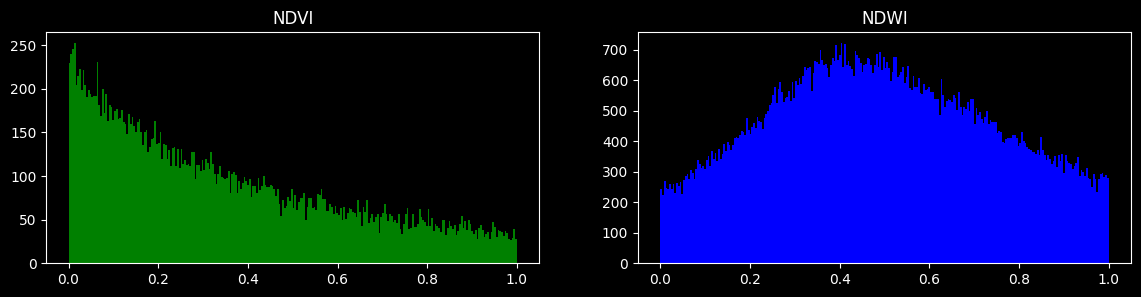

In [176]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.title("NDVI")
plt.hist(ndvi.numpy().ravel(), bins=256, range=(0, 1), color="green")

plt.subplot(1, 2, 2)
plt.title("NDWI")
plt.hist(ndwi.numpy().ravel(), bins=256, range=(0, 1), color="blue")
plt.show()

Let's count the number of pixels with NDVI and NDWI values above 0.0.

In [119]:
def count_threshold(img, threshold):
    return tf.math.count_nonzero(img > threshold)

In [120]:
ndvi_count = count_threshold(ndvi, 0.0)
ndwi_count = count_threshold(ndwi, 0.0)

print("NDVI #: ", ndvi_count.numpy(), "NDWI #: ", ndwi_count.numpy())
print("NDVI %: ", ndvi_count.numpy() / (256 * 256), "NDWI %: ", ndwi_count.numpy() / (256 * 256))


NDVI #:  36814 NDWI #:  159794
NDVI %:  0.561737060546875 NDWI %:  2.438262939453125


# Conclusion
Let's put it together, show tiles of vegetation health and irrigation patterns.

## Vegetation tiling
To reduce complexity and make the image more readable, we will tile the vegetation health index i.e. instead o fmany small points, we will have larger tiles of the same color.

In [123]:
def average_tiles(image_tensor, tile_size):
    """
    Average out tiles of the specified size in the given image tensor.

    Parameters:
    - image_tensor: TensorFlow tensor of shape [1, height, width, channels]
    - tile_size: Tuple representing the size of each tile (e.g., (64, 64))

    Returns:
    - A new tensor with averaged tiles.
    """

    # Extracting relevant dimensions
    batch_size, height, width, channels = image_tensor.shape

    # Calculating the number of tiles in each dimension
    num_tiles_height = height // tile_size[0]
    num_tiles_width = width // tile_size[1]

    # Reshape the image tensor into tiles
    image_tiles = tf.image.extract_patches(
        images=image_tensor,
        sizes=[1, tile_size[0], tile_size[1], 1],
        strides=[1, tile_size[0], tile_size[1], 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )

    # Reshape the tiles to calculate the average
    image_tiles_reshaped = tf.reshape(
        image_tiles, [batch_size, num_tiles_height, num_tiles_width, -1, channels]
    )

    # Calculate the average across the last dimension (tiles)
    averaged_tiles = tf.reduce_mean(image_tiles_reshaped, axis=-2)

    return averaged_tiles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


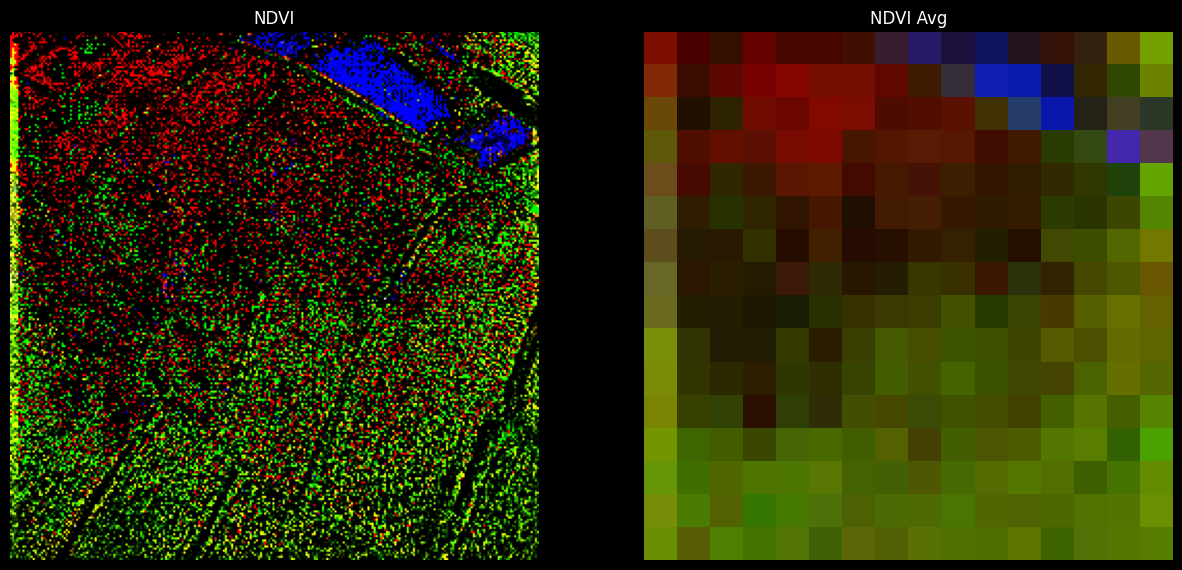

In [142]:
ndvi_avg = average_tiles(ndvi_roi, (16, 16))
plt.figure(figsize=(15, 15))

display_list = [ndvi[0], ndvi_avg[0]]
title = ["NDVI", "NDVI Avg"]

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    
    tmp = normalize(display_list[i], 0, 1)
    
    plt.imshow(normalize((display_list[i]), 0, 1))
    
    # create colorbar from 0 to 1 for the colors in the image
    
    plt.axis("off")

Check how distributions changed after tiling.

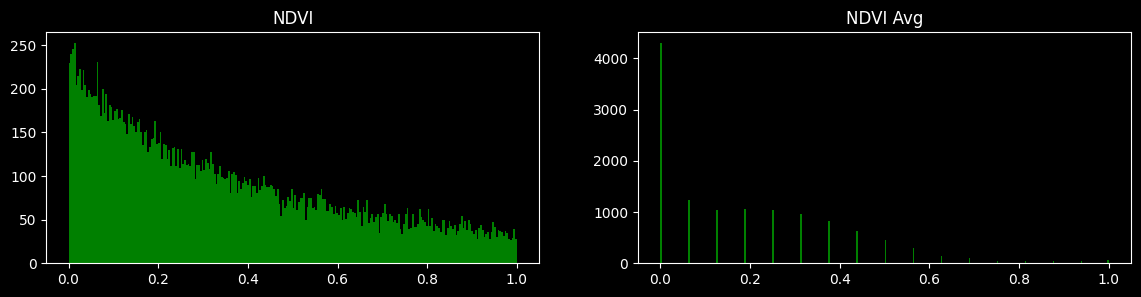

In [125]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.title("NDVI")
plt.hist(ndvi.numpy().ravel(), bins=256, range=(0, 1), color="green")

plt.subplot(1, 2, 2)
plt.title("NDVI Avg")
plt.hist(ndvi_avg.numpy().ravel(), bins=256, range=(0, 1), color="green")

plt.show()

## Irrigation paths
Let's first remove NDWI data we don't need, for now let's remove any NDWI values not inside a vegetation tile.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


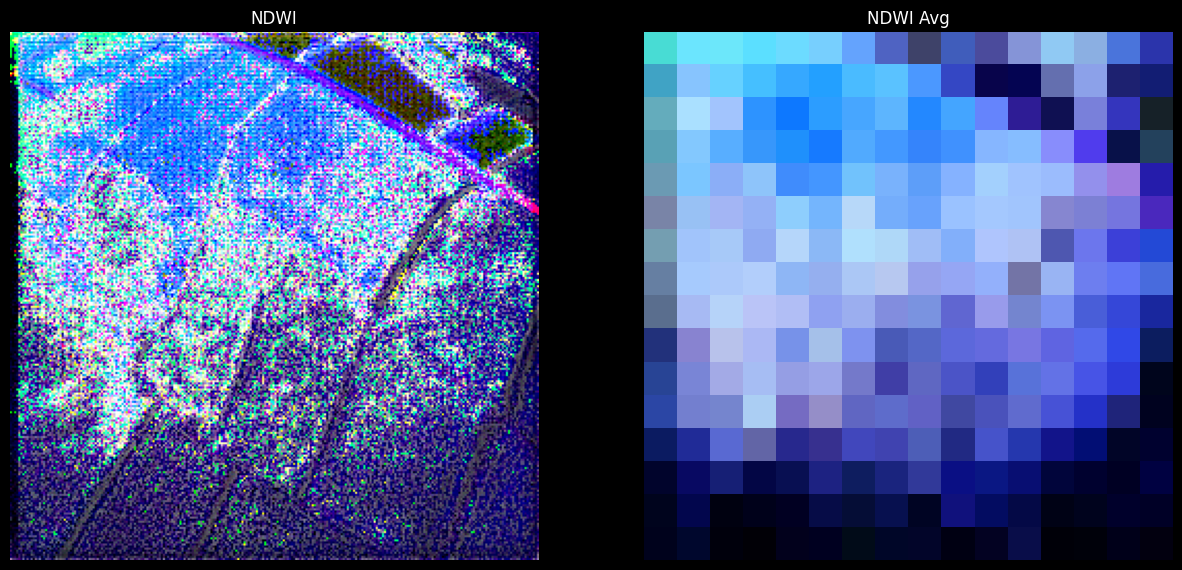

In [183]:
ndwi_avg = average_tiles(ndwi_roi, (16, 16))
plt.figure(figsize=(15, 15))

display_list = [ndwi[0], ndwi_avg[0]]
title = ["NDWI", "NDWI Avg"]

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    
    plt.imshow(normalize((display_list[i]), 0, 1))
        
    plt.axis("off")

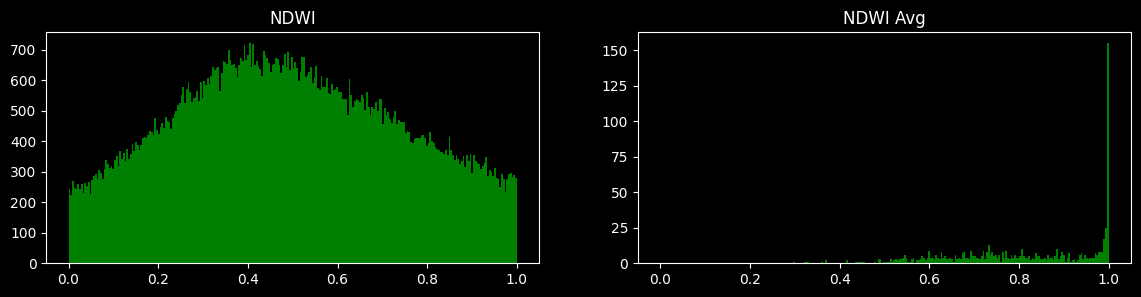

In [157]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 2, 1)
plt.title("NDWI")
plt.hist(ndwi.numpy().ravel(), bins=256, range=(0, 1), color="green")

plt.subplot(1, 2, 2)
plt.title("NDWI Avg")
plt.hist(ndwi_avg.numpy().ravel(), bins=256, range=(0, 1), color="green")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


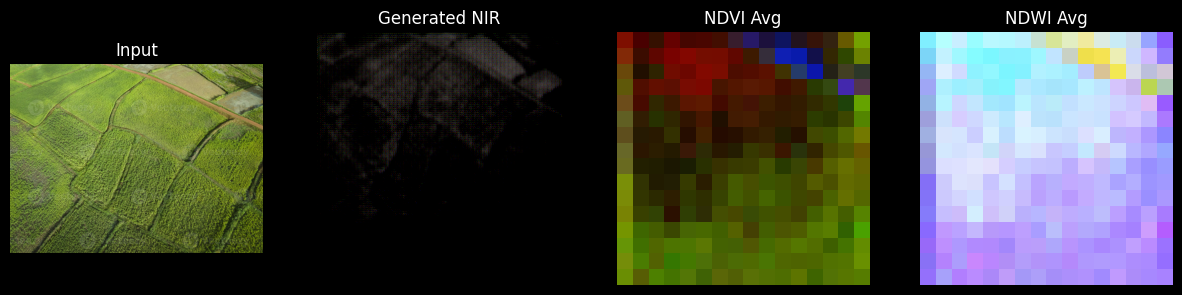

In [164]:
plot_graphs([image, prediction[0], ndvi_avg[0], ndwi_avg[0]], ["Input", "Generated NIR", "NDVI Avg", "NDWI Avg"])